In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN
from data import fmap
import functools
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Parameters

In [51]:
ns = 32
try_resume = False
Mpch=70
c = 20000
shift = 3
forward = functools.partial(fmap.stat_forward, c=c, shift=shift)
backward = functools.partial(fmap.stat_backward, c=c, shift=shift)

# Data handling

Load the data

In [52]:
dataset = data.load.load_dataset(spix=ns, resolution=256,Mpch=Mpch, forward_map=forward)

min: 1.153923623320452e-09
max: 4.804569108053774


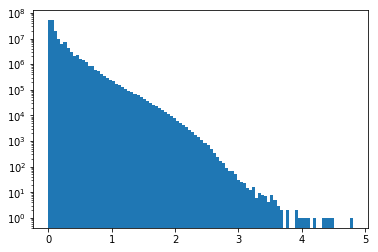

In [53]:
X = dataset.get_all_data().flatten()
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

Let us plot 16 images

In [ ]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [ ]:
time_str = 'stat_c_{}_shift_{}_laplacian{}'.format(c, Mpch, shift)
global_path = '/scratch/snx3000/nperraud/saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [ ]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = tf.nn.relu

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 5


params_cosmology = dict()
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward
params_cosmology['Nstats'] = 5000


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'laplacian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = os.path.join(global_path, params['name'] + '_' + time_str +'_summary/')
params['save_dir'] = os.path.join(global_path,params['name'] + '_' + time_str + '_checkpoints/')



In [ ]:
resume, params = utils.test_resume(try_resume, params)

## Build the model

In [ ]:
wgan = CosmoGAN(params, WGanModel)

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [ ]:
wgan.train(dataset, resume=resume)

In [ ]:
gen_sample, gen_sample_raw = wgan.generate(N=2000)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

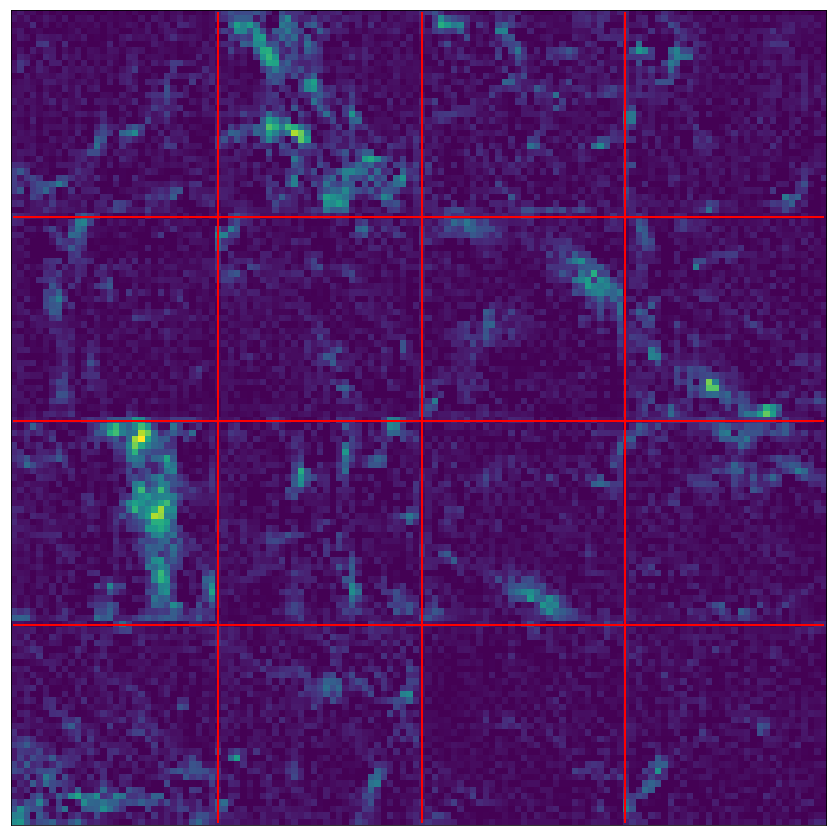

In [14]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [15]:
raw_images = backward(dataset.get_samples(dataset.N))

Log l2 PSD loss: 2.561099645804325
L2 PSD loss: 52642.77042024486
Log l1 PSD loss: 1.4571746013721874
L1 PSD loss: 219.02801926045288


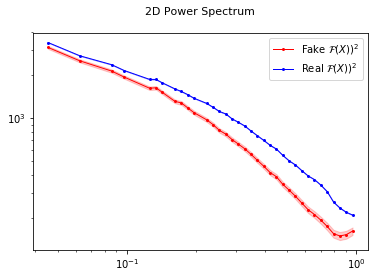

In [16]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 2.3264643046127897
L2 Peak Count loss: 2.4690675205043338
Log l1 Peak Count loss: 1.2797610438536084
L1 Peak Count loss: 0.5964821655273437


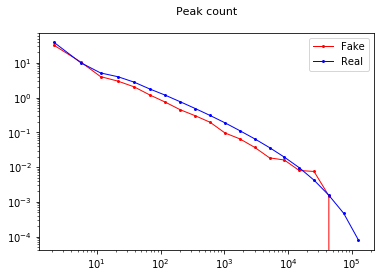

In [17]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Using new limits
Log l2 Mass histogram loss: 0.7630532810567727
L2 Peak Mass histogram: 19.037239004498865
Log l1 Mass histogram loss: 0.6467594023519837
L1 Mass histogram loss: 2.077990917968746


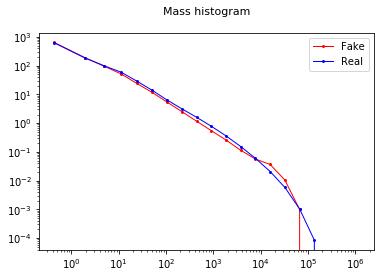

In [18]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)